# Take some RNN models from tensorflow seq2seq:

NOTE: much of this code was taken and modified from tensorflows github repository. Also this code is only compatible with an old version of tensorflow (0.10)

- [x] For test data, show input batch words, output words, and predicted words (and print this to a file every so often)

- [x] Switch to `embedding_rnn_seq2seq` model

- [x] Capture word embeddings

- [x] Normalize word embeddings

- [x] Implement VAE

- [x] Capture z's and latent loss

- Minimize latent loss (hopefully this helps prevent exploding gradients !!)

- [x] Get good summaries of Error, etc written to files during training

- Any more finishing of model using original en -> fr data. Such as saving the tensorboard graph model.

Figures:

1. model diagram
2. Training curves
3. token embeddings
4. visualize latent (color by sequence families or GO category)
5. reconstruction (multiple seq alignment)

## Now simply apply to protein data

- Run protein data through the system using same tokenization machinery as for en -> fr translation

- Have to change bucket sizes appropriatly

- Tokenize 2 amino acids to get 400 total combos because easier to analyze embeddings. See if order matters ie does XY = YX ?

- Color latent space by sequence attributes

## Exploding Gradients are scary, no joke!!!!!

In [1]:
# dependencies

import math
import os
import random
import sys
import time

import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.ops import rnn, rnn_cell, variable_scope, array_ops
from tensorflow.python.ops.seq2seq import sequence_loss, embedding_rnn_decoder, embedding_attention_decoder

# import data_utils
import data_utils
from data_utils import create_vocabulary, initialize_vocabulary, data_to_token_ids

# VAE model

In [2]:
def make_vae(x):
  """ Takes a numeric tensor and returns the reconstructed mean tensor of same dims
  (batch_size, input_dim)"""

  # A lot of this code section is taken and modified from https://jmetzen.github.io/2015-11-27/vae.html

  # hyper params:
  n_input=size*2

  # CREATE NETWORK

  # 2) weights and biases variables
  def xavier_init(fan_in, fan_out, constant=1): 
      """ Xavier initialization of network weights"""
      # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
      low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
      high = constant*np.sqrt(6.0/(fan_in + fan_out))
      return tf.random_uniform(shape=[fan_in, fan_out], minval=low, maxval=high, dtype=tf.float32)

  w_sigma = tf.Variable(xavier_init(n_input, n_z))
  w_mean = tf.Variable(xavier_init(n_input, n_z))
  w_reconstr = tf.Variable(xavier_init(n_z, n_input))
  
  b_sigma = tf.Variable(tf.zeros([n_z], dtype=tf.float32))
  b_mean = tf.Variable(tf.zeros([n_z], dtype=tf.float32))
  b_reconstr = tf.Variable(tf.zeros([n_input], dtype=tf.float32))

  # 3) recognition network

  # use recognition network to predict mean and (log) variance of (latent) Gaussian distribution z (n_z dimensional)
  z_mean = tf.add(tf.matmul(x, w_mean), b_mean)
  z_sigma = tf.add(tf.matmul(x, w_sigma), b_sigma)

  # 4) do sampling on recognition network to get latent variables
  # draw one n_z dimensional sample (for each input in batch), from normal distribution
  eps = tf.random_normal([n_z], 0, 1, dtype=tf.float32)

  # scale that set of samples by predicted mu and epsilon to get samples of z, the latent distribution
  # z = mu + sigma*epsilon
  latent_z = tf.add(z_mean, tf.mul(tf.sqrt(tf.exp(z_sigma)), eps), name="latent_z")

  # 5) use generator network to predict mean of Bernoulli distribution of reconstructed input
  x_reconstr_mean = tf.nn.sigmoid(tf.add(tf.matmul(latent_z, w_reconstr), b_reconstr))

  # 6) loss
  latent_loss = tf.mul(-0.5, tf.reduce_sum(1 + z_sigma - tf.square(z_mean) - tf.exp(z_sigma), 1), name="latent_loss")

  return x_reconstr_mean, latent_z, latent_loss

# model components from tensorflow

In [3]:
def embedding_attention_seq2seq(encoder_inputs, decoder_inputs, cell,
                                num_heads=1, output_projection=None,
                                feed_previous=False, dtype=None, scope=None,
                                initial_state_attention=False):
  """taken (with modification from tensorflow) so look up docstrings elsewhere"""

  with variable_scope.variable_scope(
      scope or "embedding_attention_seq2seq", dtype=dtype) as scope:
    dtype = scope.dtype
    # Encoder.
    encoder_cell = rnn_cell.EmbeddingWrapper(
        cell, embedding_classes=source_vocab_size,
        embedding_size=size)
    encoder_outputs, encoder_state = rnn.rnn(
        encoder_cell, encoder_inputs, dtype=dtype)
    
    # Patrick: keep your eyes on that encoder state
    encoder_state, latent_z, latent_loss = make_vae(encoder_state)

    # First calculate a concatenation of encoder outputs to put attention on.
    top_states = [array_ops.reshape(e, [-1, 1, cell.output_size])
                  for e in encoder_outputs]
    attention_states = array_ops.concat(1, top_states)

    # Decoder.
    output_size = None
    if output_projection is None:
      cell = rnn_cell.OutputProjectionWrapper(cell, target_vocab_size)
      output_size = target_vocab_size

    if isinstance(feed_previous, bool):
      outputs, state = embedding_attention_decoder(
          decoder_inputs,
          encoder_state,
          attention_states,
          cell,
          target_vocab_size,
          size,
          num_heads=num_heads,
          output_size=output_size,
          output_projection=output_projection,
          feed_previous=feed_previous,
          initial_state_attention=initial_state_attention)
      return outputs, state, latent_z, latent_loss

    # If feed_previous is a Tensor, we construct 2 graphs and use cond.
    def decoder(feed_previous_bool):
      reuse = None if feed_previous_bool else True
      with variable_scope.variable_scope(
          variable_scope.get_variable_scope(), reuse=reuse) as scope:
        outputs, state = embedding_attention_decoder(
            decoder_inputs,
            encoder_state,
            attention_states,
            cell,
            target_vocab_size,
            size,
            num_heads=num_heads,
            output_size=output_size,
            output_projection=output_projection,
            feed_previous=feed_previous_bool,
            update_embedding_for_previous=False,
            initial_state_attention=initial_state_attention)
        state_list = [state]
        if nest.is_sequence(state):
          state_list = nest.flatten(state)
        return outputs + state_list

    outputs_and_state = control_flow_ops.cond(feed_previous,
                                              lambda: decoder(True),
                                              lambda: decoder(False))
    outputs_len = len(decoder_inputs)  # Outputs length same as decoder inputs.
    state_list = outputs_and_state[outputs_len:]
    state = state_list[0]
    if nest.is_sequence(encoder_state):
      state = nest.pack_sequence_as(structure=encoder_state,
                                    flat_sequence=state_list)
  return outputs_and_state[:outputs_len], state, latent_z, latent_loss

def embedding_rnn_seq2seq(encoder_inputs, decoder_inputs, cell,
                          output_projection=None,
                          feed_previous=False, dtype=dtypes.float32,
                          scope=None,):
  """taken (with modification from tensorflow) so look up docstrings elsewhere"""
  with variable_scope.variable_scope(scope or "embedding_rnn_seq2seq"):
    # Encoder.
    encoder_cell = rnn_cell.EmbeddingWrapper(
        cell, embedding_classes=source_vocab_size,
        embedding_size=size)
    _, encoder_state = rnn.rnn(encoder_cell, encoder_inputs, dtype=dtype)
    
    # Patrick: keep your eyes on that encoder state
    encoder_state, latent_z, latent_loss = make_vae(encoder_state)

    # Decoder.
    if output_projection is None:
      cell = rnn_cell.OutputProjectionWrapper(cell, target_vocab_size)

    if isinstance(feed_previous, bool):
      outputs, state = embedding_rnn_decoder(
          decoder_inputs, encoder_state, cell, target_vocab_size,
          size, output_projection=output_projection,
          feed_previous=feed_previous)
      return outputs, state, latent_z, latent_loss

    # If feed_previous is a Tensor, we construct 2 graphs and use cond.
    def decoder(feed_previous_bool):
      reuse = None if feed_previous_bool else True
      with variable_scope.variable_scope(variable_scope.get_variable_scope(),
                                         reuse=reuse):
        outputs, state = embedding_rnn_decoder(
            decoder_inputs, encoder_state, cell, target_vocab_size,
            size, output_projection=output_projection,
            feed_previous=feed_previous_bool,
            update_embedding_for_previous=False)
        state_list = [state]
        if nest.is_sequence(state):
          state_list = nest.flatten(state)
        return outputs + state_list

    outputs_and_state = control_flow_ops.cond(feed_previous,
                                              lambda: decoder(True),
                                              lambda: decoder(False))
    outputs_len = len(decoder_inputs)  # Outputs length same as decoder inputs.
    state_list = outputs_and_state[outputs_len:]
    state = state_list[0]
    if nest.is_sequence(encoder_state):
      state = nest.pack_sequence_as(structure=encoder_state, flat_sequence=state_list)
    
    return outputs_and_state[:outputs_len], state, latent_z, latent_loss
  
def model_with_buckets(encoder_inputs, decoder_inputs, targets, weights,
                       buckets, feed_previous, cell, output_projection=None,
                       softmax_loss_function=None, name=None):
  """taken (with modification from tensorflow) so look up docstrings elsewhere"""

  all_inputs = encoder_inputs + decoder_inputs + targets + weights
  losses = []
  outputs = []
  
  latent_losses = []
  latent_zs = []
  
  with ops.op_scope(all_inputs, name, "model_with_buckets"):
    for j, bucket in enumerate(buckets):
      with variable_scope.variable_scope(variable_scope.get_variable_scope(),
                                         reuse=True if j > 0 else None):
        bucket_outputs, _, latent_z, latent_loss = embedding_attention_seq2seq(
            encoder_inputs[:bucket[0]],
            decoder_inputs[:bucket[1]],
            cell,
            output_projection=output_projection,
            feed_previous=feed_previous)
        
        outputs.append(bucket_outputs)
        
        latent_losses.append(tf.reduce_mean(latent_loss))
        latent_zs.append(latent_z)
        
        losses.append(sequence_loss(
            outputs[-1], targets[:bucket[1]], weights[:bucket[1]],
            softmax_loss_function=softmax_loss_function))

  return outputs, losses, latent_losses, latent_zs

# The translation model:

In [4]:
class Seq2SeqModel(object):
  """taken (with modification from tensorflow) so look up docstrings elsewhere"""
  def __init__(self,
               buckets,
               size,
               num_layers,
               max_gradient_norm,
               batch_size,
               learning_rate,
               learning_rate_decay_factor,
               use_lstm=False,
               num_samples=512,
               forward_only=False,
               dtype=tf.float32):
    
    self.buckets = buckets
    self.learning_rate = tf.Variable(
        float(learning_rate), trainable=False, dtype=dtype)
    self.learning_rate_decay_op = self.learning_rate.assign(
        self.learning_rate * learning_rate_decay_factor)
    self.global_step = tf.Variable(0, trainable=False)

    # If we use sampled softmax, we need an output projection.
    output_projection = None
    softmax_loss_function = None
    # Sampled softmax only makes sense if we sample less than vocabulary size.
    if num_samples > 0 and num_samples < target_vocab_size:
      w_t = tf.get_variable("proj_w", [target_vocab_size, size], dtype=dtype)
      w = tf.transpose(w_t)
      b = tf.get_variable("proj_b", [target_vocab_size], dtype=dtype)
      output_projection = (w, b)

      def sampled_loss(inputs, labels):
        labels = tf.reshape(labels, [-1, 1])
        # We need to compute the sampled_softmax_loss using 32bit floats to
        # avoid numerical instabilities.
        local_w_t = tf.cast(w_t, tf.float32)
        local_b = tf.cast(b, tf.float32)
        local_inputs = tf.cast(inputs, tf.float32)
        return tf.cast(
            tf.nn.sampled_softmax_loss(local_w_t, local_b, local_inputs, labels,
                                       num_samples, target_vocab_size),dtype)
      
      softmax_loss_function = sampled_loss

    # Create the internal multi-layer cell for our RNN.
    single_cell = tf.nn.rnn_cell.GRUCell(size)
    if use_lstm:
      single_cell = tf.nn.rnn_cell.BasicLSTMCell(size)
    cell = single_cell
    if num_layers > 1:
      cell = tf.nn.rnn_cell.MultiRNNCell([single_cell] * num_layers)

    # Feeds for inputs.
    self.encoder_inputs = []
    self.decoder_inputs = []
    self.target_weights = []
    for i in range(buckets[-1][0]):  # Last bucket is the biggest one.
      self.encoder_inputs.append(tf.placeholder(tf.int32, shape=[None],
                                                name="encoder{0}".format(i)))
    for i in range(buckets[-1][1] + 1):
      self.decoder_inputs.append(tf.placeholder(tf.int32, shape=[None],
                                                name="decoder{0}".format(i)))
      self.target_weights.append(tf.placeholder(dtype, shape=[None],
                                                name="weight{0}".format(i)))

    # Our targets are decoder inputs shifted by one.
    targets = [self.decoder_inputs[i + 1] for i in range(len(self.decoder_inputs) - 1)]
    
    # Training outputs and losses.
    if forward_only:
      self.outputs, self.losses, self.latent_losses, self.latent_zs = model_with_buckets(
          self.encoder_inputs, self.decoder_inputs, targets,
          self.target_weights, buckets,
          feed_previous=True,
          cell=cell,
          softmax_loss_function=softmax_loss_function,
          output_projection=output_projection
      )
      # If we use output projection, we need to project outputs for decoding.
      if output_projection is not None:
        for b in range(len(buckets)):
          self.outputs[b] = [
              tf.matmul(output, output_projection[0]) + output_projection[1]
              for output in self.outputs[b]
          ]
    else:
      self.outputs, self.losses, self.latent_losses, self.latent_zs = model_with_buckets(
          self.encoder_inputs, self.decoder_inputs, targets,
          self.target_weights, buckets,
          feed_previous=False,
          cell=cell,
          softmax_loss_function=softmax_loss_function,
          output_projection=output_projection)

    # Gradients and SGD update operation for training the model.
    params = tf.trainable_variables()
    if not forward_only:
      self.gradient_norms = []
      self.updates = []
      opt = tf.train.GradientDescentOptimizer(self.learning_rate)
      for b in range(len(buckets)):
        gradients = tf.gradients(self.losses[b] + (alph_factor * self.latent_losses[b]), params)
        clipped_gradients, norm = tf.clip_by_global_norm(gradients,
                                                         max_gradient_norm)
        self.gradient_norms.append(norm)
        self.updates.append(opt.apply_gradients(
            zip(clipped_gradients, params), global_step=self.global_step))

    self.saver = tf.train.Saver(tf.all_variables())

  def step(self, session, encoder_inputs, decoder_inputs, target_weights,
           bucket_id, forward_only):

    # encoder and decoder sizes must match the corresponding bucket
    encoder_size = len(encoder_inputs)
    decoder_size = len(decoder_inputs)

    # Input feed: encoder inputs, decoder inputs, target_weights, as provided.
    input_feed = {}
    for l in range(encoder_size):
      input_feed[self.encoder_inputs[l].name] = encoder_inputs[l]
    for l in range(decoder_size):
      input_feed[self.decoder_inputs[l].name] = decoder_inputs[l]
      input_feed[self.target_weights[l].name] = target_weights[l]

    # Since our targets are decoder inputs shifted by one, we need one more.
    last_target = self.decoder_inputs[decoder_size].name
    input_feed[last_target] = np.zeros([batch_size], dtype=np.int32)

    # Output feed: depends on whether we do a backward step or not.
    if not forward_only:
      output_feed = [self.updates[bucket_id],  # Update Op that does SGD.
                     self.gradient_norms[bucket_id],  # Gradient norm.
                     self.losses[bucket_id],
                     self.latent_losses[bucket_id],
                     self.latent_zs[bucket_id]
                    ]  
    else:
      output_feed = [self.losses[bucket_id],
                     self.latent_losses[bucket_id],
                     self.latent_zs[bucket_id]]  # Loss for this batch.
      
      for l in range(decoder_size):  # Output logits.
        output_feed.append(self.outputs[bucket_id][l])

    outputs = session.run(output_feed, input_feed)
    
    # this seems like ugly code, my bad ;(
    if not forward_only:
      return outputs[1], outputs[2], None, outputs[3], outputs[4]
    else:
      return None, outputs[0], outputs[3:], outputs[1], outputs[2]

    
  def get_batch(self, data, bucket_id, sample=True):

    encoder_size, decoder_size = self.buckets[bucket_id]
    encoder_inputs, decoder_inputs = [], []

    if sample:
      # Get a random batch of encoder and decoder inputs from data,
      # pad them if needed, reverse encoder inputs and add GO to decoder.
      for i in range(batch_size):
        encoder_input, decoder_input = random.choice(data[bucket_id])

        # Encoder inputs are padded and then reversed.
        encoder_pad = [data_utils.PAD_ID] * (encoder_size - len(encoder_input))
        encoder_inputs.append(list(reversed(encoder_input + encoder_pad)))

        # Decoder inputs get an extra "GO" symbol, and are padded then.
        decoder_pad_size = decoder_size - len(decoder_input) - 1
        decoder_inputs.append([data_utils.GO_ID] + decoder_input +
                              [data_utils.PAD_ID] * decoder_pad_size)
    else:
      for i in range(batch_size):
        encoder_input, decoder_input = data[bucket_id][i]

        # Encoder inputs are padded and then reversed.
        encoder_pad = [data_utils.PAD_ID] * (encoder_size - len(encoder_input))
        encoder_inputs.append(list(reversed(encoder_input + encoder_pad)))

        # Decoder inputs get an extra "GO" symbol, and are padded then.
        decoder_pad_size = decoder_size - len(decoder_input) - 1
        decoder_inputs.append([data_utils.GO_ID] + decoder_input +
                              [data_utils.PAD_ID] * decoder_pad_size)

    # Now we create batch-major vectors from the data selected above.
    batch_encoder_inputs, batch_decoder_inputs, batch_weights = [], [], []

    # Batch encoder inputs are just re-indexed encoder_inputs.
    for length_idx in range(encoder_size):
      batch_encoder_inputs.append(
          np.array([encoder_inputs[batch_idx][length_idx]
                    for batch_idx in range(batch_size)], dtype=np.int32))

    # Batch decoder inputs are re-indexed decoder_inputs, we create weights.
    for length_idx in range(decoder_size):
      batch_decoder_inputs.append(
          np.array([decoder_inputs[batch_idx][length_idx]
                    for batch_idx in range(batch_size)], dtype=np.int32))

      # Create target_weights to be 0 for targets that are padding.
      batch_weight = np.ones(batch_size, dtype=np.float32)
      for batch_idx in range(batch_size):
        # We set weight to 0 if the corresponding target is a PAD symbol.
        # The corresponding target is decoder_input shifted by 1 forward.
        if length_idx < decoder_size - 1:
          target = decoder_inputs[batch_idx][length_idx + 1]
        if length_idx == decoder_size - 1 or target == data_utils.PAD_ID:
          batch_weight[batch_idx] = 0.0
      batch_weights.append(batch_weight)
    return batch_encoder_inputs, batch_decoder_inputs, batch_weights
  
def make_dir(directory):
  if not os.path.exists(directory):
    os.makedirs(directory)
  return directory

# Do training:

In [5]:
alph_factor = 1
learning_rate = 0.5
learning_rate_decay_factor = 0.99
max_gradient_norm = 2.0 # control exploding gradients !!
batch_size = 32
size = 38 # both the embedding size and the RNN state size
n_z = 26
num_layers = 2
source_vocab_size = 20
target_vocab_size = 20
train_dir = make_dir("seq2seq_train_protein/")
max_train_data_size = 6100000
steps_per_checkpoint = 1500
do_self_test = False

# We use a number of buckets and pad to the closest one for efficiency.
# See Seq2SeqModel for details of how they work.
_buckets = [(40, 40), (60, 60), (80, 80), (100, 100)]

def read_data(source_path, target_path, max_size=None):
  """taken (with modification from tensorflow) so look up docstrings elsewhere"""
  data_set = [[] for _ in _buckets]
  with tf.gfile.GFile(source_path, mode="r") as source_file:
    with tf.gfile.GFile(target_path, mode="r") as target_file:
      source, target = source_file.readline(), target_file.readline()
      counter = 0
      while source and target and (not max_size or counter < max_size):
        counter += 1
        if counter % 100000 == 0:
          print("  reading data line %d" % counter)
          sys.stdout.flush()
        source_ids = [int(x) for x in source.split()]
        target_ids = [int(x) for x in target.split()]
        target_ids.append(data_utils.EOS_ID)
        for bucket_id, (source_size, target_size) in enumerate(_buckets):
          if len(source_ids) < source_size and len(target_ids) < target_size:
            data_set[bucket_id].append([source_ids, target_ids])
            break
        source, target = source_file.readline(), target_file.readline()
  return data_set

def create_model(session, forward_only):
  """Create translation model and initialize or load parameters in session."""
  model = Seq2SeqModel(
      _buckets,
      size,
      num_layers,
      max_gradient_norm,
      batch_size,
      learning_rate,
      learning_rate_decay_factor,
      forward_only=forward_only)

  ckpt = tf.train.get_checkpoint_state(train_dir)
  if ckpt and tf.gfile.Exists(ckpt.model_checkpoint_path):
    print("Reading model parameters from %s" % ckpt.model_checkpoint_path)
    model.saver.restore(session, ckpt.model_checkpoint_path)
  else:
    print("Created model with fresh parameters.")
    session.run(tf.initialize_all_variables())
  return model
      
def write_batch_input_output_prediction_to_file(n_examples=5, n_sample=3):
  # note_ n_examples must be less than or equal to the batch size
  s = ""
  input_seqs = []
  enc_inputs_npa = np.array([list(ar) for ar in encoder_inputs]).T
  
  for sent_id in range(batch_size):
    sent_in = enc_inputs_npa[sent_id]
    str_input_seq = str(sent_id) + ": " + " ".join(
      reversed([rev_vocab[n].decode("utf8") for n in sent_in if n != 0])
    ) + "\n"
    input_seqs.append(str_input_seq)
    
  for sent_id in range(n_examples):
    # print n_examples of "real" inputs
    sent_in = enc_inputs_npa[sent_id]
    s += input_seqs[sent_id]
    
    # for each "real" input, print n_sample samples
    for sample_id in range(n_sample):
      _, eval_loss, output_logits, latent_loss, latent_z = model.step(sess, encoder_inputs,
                                                 decoder_inputs, target_weights, bucket_id, True)
      pred_outputs = np.array([list(np.argmax(logit, axis=1)) for logit in output_logits]).T
      s += str(sent_id) + ": " + " ".join([rev_vocab[n].decode("utf8") for n in pred_outputs[sent_id] if n != 0]) + "\n"


  with open(train_dir + "batch_trans_" + str(int(g_step)) + "_bucket_" + str(bucket_id) + ".txt", "w") as f:
    f.write(s)
    
  # print log of latent space (over the test batch)
  df = pd.DataFrame(latent_z, index=input_seqs)
  df.to_csv(train_dir + "latent_z_{}_{}.txt".format(bucket_id, g_step), sep=" ", header=False)


if do_self_test:
  source_vocab_size = 10
  target_vocab_size = 10
  
  """Test the translation model."""
  sess = tf.Session() # make new session (no loading of saved session)
  print("Self-test for neural translation model.")
  # Create model with vocabularies of 10, 2 small buckets, 2 layers of 32.
  model = Seq2SeqModel(
      [(3, 3),(6, 6)], # buckets (max_en, max_fr)
      512, # size
      2, # num layers
      5.0, # max gradient norm
      batch_size, # batch size
      0.3, # learning rate
      0.99, # learning rate decay factor
      use_lstm=False,
      num_samples=8, # number of samples for sampled softmax
      forward_only=False, # run 1-directional rnn (or something like that)
      )
  sess.run(tf.initialize_all_variables())

  data_set = ([([1, 1], [2, 2]), ([3, 3], [4]), ([5], [6])],
              [([1, 1, 1, 1, 1], [2, 2, 2, 2, 2]), ([3, 3, 3], [5, 6])])
  for _ in range(10):  # Train the fake model for 5 steps.
    bucket_id = random.choice([0, 1]) # choose a bucket
    encoder_inputs, decoder_inputs, target_weights = model.get_batch(data_set, bucket_id)
    _, step_loss, output_logits, latent_loss, latent_z = model.step(sess, encoder_inputs, decoder_inputs, target_weights, bucket_id, False)
    print("step_loss: {}, latent_loss: {}, latent_z: {}".format(step_loss, latent_loss, latent_z))

else:
  sess = tf.Session()

  def init_vocabs():
    data_file = "protein_data/protein.txt"
    dev_data_file = "protein_data/protein_dev.txt"
    vocab_file = "protein_data/vocab.txt"

    dev_token_file = "protein_data/dev_token.txt"
    data_token_file = "protein_data/token.txt"

    # use same data as input and output (autoencoder)
    create_vocabulary(vocab_file, data_file, source_vocab_size, None)
    data_to_token_ids(dev_data_file, dev_token_file, vocab_file, None)
    data_to_token_ids(data_file, data_token_file, vocab_file, None)
    
    dev_set = read_data(dev_token_file, dev_token_file)
    train_set = read_data(data_token_file, data_token_file, max_train_data_size)
    vocab, rev_vocab = initialize_vocabulary(vocab_file)

    return vocab, rev_vocab, dev_set, train_set

  vocab, rev_vocab, dev_set, train_set = init_vocabs()
  
  sess = tf.Session()
  # Create model.
  print("Creating %d layers of %d units." % (num_layers, size))
  model = create_model(sess, False)

  # Read data into buckets and compute their sizes.
  print ("Reading development and training data (limit: %d)."
         % max_train_data_size)
#   dev_set = read_data(en_dev, fr_dev)
#   train_set = read_data(en_train, fr_train, max_train_data_size)
  train_bucket_sizes = [len(train_set[b]) for b in range(len(_buckets))]
  train_total_size = float(sum(train_bucket_sizes))

  # A bucket scale is a list of increasing numbers from 0 to 1 that we'll use
  # to select a bucket. Length of [scale[i], scale[i+1]] is proportional to
  # the size if i-th training bucket, as used later.
  train_buckets_scale = [sum(train_bucket_sizes[:i + 1]) / train_total_size
                         for i in range(len(train_bucket_sizes))]

  # This is the training loop.
  step_time, loss, l_loss = 0.0, 0.0, 0.0
  current_step = 0
  previous_losses = []
  while True:
    # Choose a bucket according to data distribution. We pick a random number
    # in [0, 1] and use the corresponding interval in train_buckets_scale.
    random_number_01 = np.random.random_sample()
    bucket_id = min([i for i in range(len(train_buckets_scale))
                     if train_buckets_scale[i] > random_number_01])

    # Get a batch and make a step.
    start_time = time.time()
    encoder_inputs, decoder_inputs, target_weights = model.get_batch(
        train_set, bucket_id)
    _, step_loss, _, latent_loss, _ = model.step(sess, encoder_inputs, decoder_inputs,
                                 target_weights, bucket_id, False)
    step_time += (time.time() - start_time) / steps_per_checkpoint
    loss += step_loss / steps_per_checkpoint
    l_loss += latent_loss / steps_per_checkpoint

    # Once in a while, we save checkpoint, print statistics, and run evals.
    if current_step % steps_per_checkpoint == 0: # --------------------------------------
      print("logging summaries and errors in: " + train_dir)
      # Print statistics for the previous epoch.
      perplexity = math.exp(float(loss)) if loss < 300 else float("inf")
      g_step = sess.run(model.global_step)
      l_rate = sess.run(model.learning_rate)
      with open(train_dir + "error_train_log.txt", "a") as f:
        f.write("train {} {} {}\n".format(l_rate, loss, l_loss))
      # Decrease learning rate if no improvement was seen over last 3 times.
      if len(previous_losses) > 2 and loss > max(previous_losses[-3:]):
        sess.run(model.learning_rate_decay_op)
      previous_losses.append(loss)
      # Save checkpoint and zero timer and loss.
      checkpoint_path = os.path.join(train_dir, "translate.ckpt")
      model.saver.save(sess, checkpoint_path, global_step=model.global_step)
      step_time, loss, l_loss = 0.0, 0.0, 0.0
      # Run evals on development set and print their perplexity. --------------------------
      for bucket_id in range(len(_buckets)):
        # want to take a (deterministic) sample of whole bucket
        temp_batch_size = batch_size
        batch_size = len(dev_set[bucket_id])
        if len(dev_set[bucket_id]) == 0:
          with open(train_dir + "error_log.txt", "a") as f:
            f.write("test {} empty empty\n".format(bucket_id))
          continue

        encoder_inputs, decoder_inputs, target_weights = model.get_batch(dev_set, bucket_id, sample=False)
        _, eval_loss, output_logits, latent_loss, latent_z = model.step(sess, encoder_inputs,
                                                 decoder_inputs, target_weights, bucket_id, True)
        
        eval_ppx = math.exp(float(eval_loss)) if eval_loss < 300 else float("inf")
        with open(train_dir + "error_test_log.txt", "a") as f:
          f.write("test {} {} {}\n".format(bucket_id, eval_loss, latent_loss))
        
        # print text example translations (note: this should be last thing in test because we are going to do stuff)
        write_batch_input_output_prediction_to_file()
        
      # print out encoder embeddings as pandas dframe --------------------------------------
      for var in tf.trainable_variables():
        if var.name == 'embedding_attention_seq2seq/RNN/EmbeddingWrapper/embedding:0':
          input_embedd_op = var
      
      norm = tf.sqrt(tf.reduce_sum(tf.square(input_embedd_op), 1, keep_dims=True))
      normalized_embeddings = input_embedd_op / norm
      input_embedd_ar = sess.run(normalized_embeddings)
      
      token_strs = [rev_vocab[i].decode("utf8") for i in range(len(rev_vocab))]
      df = pd.DataFrame(data=input_embedd_ar[:len(rev_vocab),:], columns=list(range(input_embedd_ar.shape[1])), index=token_strs)
      df.to_csv(train_dir + "embedd_df_" + str(int(g_step)) + ".csv", sep=" ")
      
      # reset batch size
      batch_size = temp_batch_size
      
      # -------------------------------------------------------------------------------------
    current_step += 1

    # break to capture environment for debug
#     break

  reading data line 100000
  reading data line 200000
  reading data line 300000
  reading data line 400000
  reading data line 500000
  reading data line 600000
  reading data line 700000
  reading data line 800000
  reading data line 900000
  reading data line 1000000
  reading data line 1100000
  reading data line 1200000
  reading data line 1300000
  reading data line 1400000
  reading data line 1500000
  reading data line 1600000
  reading data line 1700000
  reading data line 1800000
  reading data line 1900000
  reading data line 2000000
  reading data line 2100000
  reading data line 2200000
  reading data line 2300000
  reading data line 2400000
  reading data line 2500000
  reading data line 2600000
  reading data line 2700000
  reading data line 2800000
  reading data line 2900000
  reading data line 3000000
  reading data line 3100000
  reading data line 3200000
  reading data line 3300000
  reading data line 3400000
  reading data line 3500000
  reading data line 3600000
 

KeyboardInterrupt: 

In [6]:
# description of data

# distribution of read lengths and how many in each bucket
print("train bucket sizes: {}".format(train_bucket_sizes))
print("test bucket sizes: {}".format(list([len(dev_set[i]) for i in range(len(dev_set))])))

train bucket sizes: [439891, 1130098, 2280247, 2122929]
test bucket sizes: [724, 2064, 9298, 9433]


In [7]:
import os
import psutil
process = psutil.Process(os.getpid())
print("Memory used: " + str(process.memory_info().rss/1000000000) + " GB")

Memory used: 13.384036352 GB


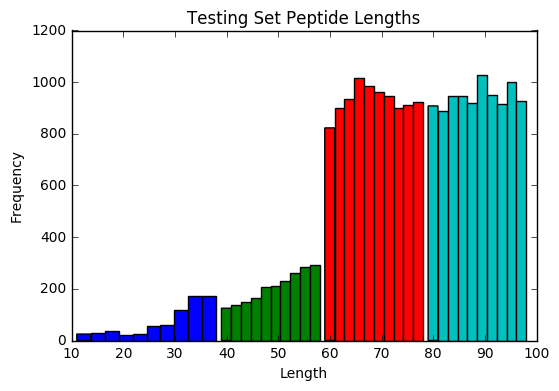

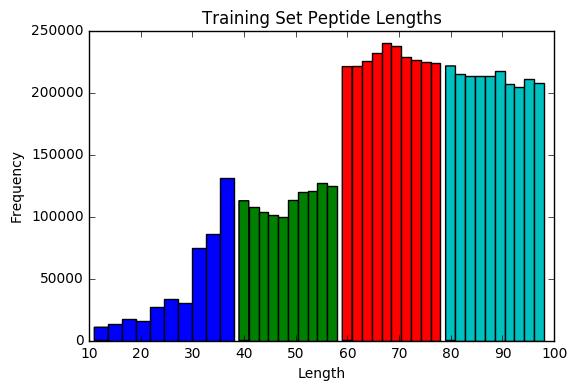

In [8]:
import matplotlib.pyplot as plt

for bucket_id in range(len(dev_set)):
  bucket_len = []
  for seq_id in range(len(dev_set[bucket_id])):
    bucket_len.append(len(dev_set[bucket_id][seq_id][0]))
  plt.hist(np.array(bucket_len))
  plt.title("Testing Set Peptide Lengths")
  plt.xlabel("Length")
  plt.ylabel("Frequency")
plt.show()
  
for bucket_id in range(len(train_set)):
  bucket_len = []
  for seq_id in range(len(train_set[bucket_id])):
    bucket_len.append(len(train_set[bucket_id][seq_id][0]))
  plt.hist(np.array(bucket_len))
  plt.title("Training Set Peptide Lengths")
  plt.xlabel("Length")
  plt.ylabel("Frequency")
plt.show()

In [9]:
# import tensorflow as tf
# import numpy as np

# def xavier_init(fan_in, fan_out, constant=1): 
#     """ Xavier initialization of network weights"""
#     # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
#     low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
#     high = constant*np.sqrt(6.0/(fan_in + fan_out))
#     return tf.random_uniform((fan_in, fan_out), minval=low, maxval=high, dtype=tf.float32)
  
# n_z = 10
# n_input = 5
# batch_size = 16

# x = tf.placeholder(tf.float32, shape=(batch_size, n_input))
# # x = tf.Variable(xavier_init(batch_size, n_input))
  
# b_mean = tf.Variable(tf.zeros([n_z], dtype=tf.float32))

# w_mean = tf.Variable(xavier_init(n_input, n_z))
  
# z_mean = tf.add(tf.matmul(x, w_mean), b_mean)

# sess = tf.Session()
# sess.run(tf.initialize_all_variables())

# # make data
# x_feed =  np.random.normal(loc=0.0, scale=1.0, size=(batch_size, n_input))
# x_feed

# # test out example graph
# # sess.run(z_mean, feed_dict={x: x_feed}).shape
# z_mean.get_shape()

In [10]:
for bucket_id in range(len(dev_set)):
  print(len(dev_set[bucket_id]))
sum([94, 270, 533, 450])

724
2064
9298
9433


1347